<a href="https://colab.research.google.com/github/linked0/deep-learning/blob/master/AAMY/Classifying_Images_of_Clothing_my.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
###### Google Colaboration ####    
* google drive 접속
from google.colab import drive
drive.mount('/content/drive')
!ln -s  'drive/My Drive' mydrive
!ls mydrive

###### file downlaod
from google.colab import files
files.download(white_output)
 
###### git partially cloning
repo='cvnd-exercises'
sub_dir='1_2_Convolutional_Filters_Edge_Detection'
url='https://github.com/linked0/' + repo + '.git'
!mkdir $repo
%cd $repo
!git init
!git remote add -f origin $url
!git config core.sparsecheckout true
!echo $sub_dir >> .git/info/sparse-checkout
!git pull --recurse-submodules origin master
%cd $sub_dir
!ls

In [2]:
!pip install -U tensorflow_datasets

    100% |████████████████████████████████| 409kB 9.1MB/s 


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

# This will go away in the future
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

1.13.1


In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataet = dataset['train'], dataset['test']

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('NUmber of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

NUmber of training examples: 60000
Number of test examples: 10000


## Preprocess the data
The value of each pixel in the image data is an integer in the range [0, 255]. For the model to work properly, these values need to be normalized to the range [0, 1]. So here we create a normalization funciton, and then apply it to each image in the test and train datasets.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataet
test_dataset = test_dataset.map(normalize)


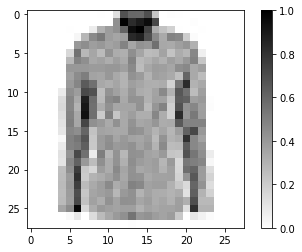

In [10]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# plot the image -  voila a piece of fashin clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

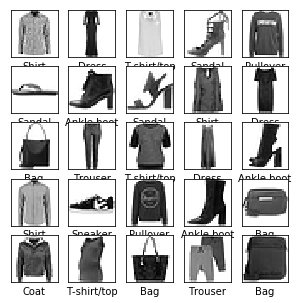

In [14]:
plt.figure(figsize=(5,5))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()